In [1]:
import os, time, sys
from pathlib import Path
import sqlite3
import cv2
import numpy as np
from matplotlib import pyplot as plt

ROOT = Path().absolute().parent
GROUND_TRUTH_PATH = Path(f"{ROOT}/datasets/DS2_Bode_Museum_Raw")
COMPARISON_PATHS = [
    Path(f"{ROOT}/datasets/DS3_Bode_Museum_Filter1")
]
GROUND_TRUTH_DB_PATH = f"{GROUND_TRUTH_PATH}/database.db"

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

COLMAP_PY_SCRIPTS_PATH = f"{ROOT}/third_party/colmap/scripts/python"
if COLMAP_PY_SCRIPTS_PATH not in sys.path:
    sys.path.append(COLMAP_PY_SCRIPTS_PATH)

In [2]:
'''
scr = f"{ROOT}/third_party/colmap/scripts/python/export_inlier_matches.py"
OUT_PATH = f"{GROUND_TRUTH_PATH}/inlier_matches.txt"
! python {scr} --database_path "{GROUND_TRUTH_DB_PATH}" --output_path "{OUT_PATH}" --min_num_matches 15

scr = f"{ROOT}/third_party/colmap/scripts/python/export_inlier_pairs.py"
OUT_PATH = f"{GROUND_TRUTH_PATH}/inlier_pairs.txt"
! python {scr} --database_path "{GROUND_TRUTH_DB_PATH}" --match_list_path "{OUT_PATH}" --min_num_matches 15

# Alternative Way of Loading Model Data!:
from read_write_model import read_model, qvec2rotmat
'''

'\nscr = f"{ROOT}/third_party/colmap/scripts/python/export_inlier_matches.py"\nOUT_PATH = f"{GROUND_TRUTH_PATH}/inlier_matches.txt"\n! python {scr} --database_path "{GROUND_TRUTH_DB_PATH}" --output_path "{OUT_PATH}" --min_num_matches 15\n\nscr = f"{ROOT}/third_party/colmap/scripts/python/export_inlier_pairs.py"\nOUT_PATH = f"{GROUND_TRUTH_PATH}/inlier_pairs.txt"\n! python {scr} --database_path "{GROUND_TRUTH_DB_PATH}" --match_list_path "{OUT_PATH}" --min_num_matches 15\n\n# Alternative Way of Loading Model Data!:\nfrom read_write_model import read_model, qvec2rotmat\n'

In [3]:
# init Colmap db reader functions from https://github.com/colmap/colmap/blob/main/scripts/python/database.py#L412
MAX_IMAGE_ID = 2 ** 31 - 1

# Note that COLMAP supports:
#      - 2D keypoints: (x, y)
#      - 4D keypoints: (x, y, theta, scale)
#      - 6D affine keypoints: (x, y, a_11, a_12, a_21, a_22)
# in the db each table has rows and columns! rows = number of entries, columns = format of entry (2D, 4D, 6D)
# e.g.: 1800 rows and 4 cols = 1800 entries of type 4D (x, y, theta, scale)

def get_image(cursor, img_id):
    cursor.execute(f"SELECT i.name, c.width, c.height FROM images as i, cameras as c WHERE c.camera_id = i.camera_id AND i.image_id = {img_id}")
    image_data = cursor.fetchone()
    image_name, width, height = image_data
    return cv2.imread(f"{GROUND_TRUTH_PATH}/images_raw/{image_name}")

def pair_id_to_image_ids(pair_id):
    image_id2 = pair_id % MAX_IMAGE_ID
    image_id1 = (pair_id - image_id2) / MAX_IMAGE_ID
    return image_id1, image_id2

def get_keypoints(cursor, img_id):
    dtype=np.float32
    #keypoints = dict(
    #    (image_id, np.frombuffer(data, dtype=dtype).reshape(*shape) )
    #    for image_id, data in cursor.execute(f"SELECT image_id, data FROM keypoints WHERE image_id={image_id}")
    #)
    keypoints = []
    result = cursor.execute(f"SELECT image_id, rows, cols, data FROM keypoints WHERE image_id={img_id}")
    for image_id, rows, cols, data in result:
        shape=(-1, cols)
        coordinates = np.frombuffer(data, dtype=dtype).reshape(*shape)
        keypoints.append({
            "image_id": int(image_id),
            "coordinates": coordinates
        })
    return keypoints

# Get all matches
def get_matches(cursor, img_ids_filter = None):
    dtype=np.uint32
    matches = []
    for pair_id, rows, cols, data in cursor.execute("SELECT pair_id, rows, cols, data FROM matches"):
        image1, image2 = pair_id_to_image_ids(pair_id)
        image1 = int(image1)
        image2 = int(image2)

        if img_ids_filter:
            assert len(img_ids_filter) > 0
            assert len(img_ids_filter) <= 2

            if len(img_ids_filter) == 1:
                # sufficient if any of both is contained
                if image1 not in img_ids_filter and image2 not in img_ids_filter:
                    continue
            else:
                # both have to be in selection!
                if not (image1 in img_ids_filter and image2 in img_ids_filter):
                    continue
        
        shape=(-1, cols)
        image_matches = np.frombuffer(data, dtype=dtype).reshape(*shape)
        matches.append({
            "pair_id": pair_id,
            "image1_id": int(image1),
            "image2_id": int(image2),
            "image_matches": image_matches
        })
    return matches

# Get the matches that are of good enough quality
def get_inlier_matches(cursor, img_ids_filter = None):
    dtype=np.uint32
    matches = []
    for pair_id, rows, cols, data in cursor.execute("SELECT pair_id, rows, cols, data FROM two_view_geometries"):
        image1, image2 = pair_id_to_image_ids(pair_id)
        image1 = int(image1)
        image2 = int(image2)

        if img_ids_filter:
            assert len(img_ids_filter) > 0
            assert len(img_ids_filter) <= 2

            if len(img_ids_filter) == 1:
                # sufficient if any of both is contained
                if image1 not in img_ids_filter and image2 not in img_ids_filter:
                    continue
            else:
                # both have to be in selection!
                if not (image1 in img_ids_filter and image2 in img_ids_filter):
                    continue
        
        shape=(-1, cols)
        image_matches = np.frombuffer(data, dtype=dtype).reshape(*shape)
        matches.append({
            "pair_id": pair_id,
            "image1_id": int(image1),
            "image2_id": int(image2),
            "image_matches": image_matches
        })
    return matches

# Get the matches that are of not good enough quality
def get_outlier_matches(cursor, img_ids_filter = None):
    all_matches = get_matches(cursor, img_ids_filter)
    inlier_matches = get_inlier_matches(cursor, img_ids_filter)
    outlier_matches = []
    for am in all_matches:
        am_clone = dict(am)
        am_clone["image_matches"] = []
        for amm in am["image_matches"]:
            if any((m == amm).all() for m in inlier_matches[0]["image_matches"]):
                continue
            am_clone["image_matches"].append(amm)
        outlier_matches.append(am_clone)
    return outlier_matches

# matches is a dict!! only one object
def get_matches_coords(cursor, matches):
    ret = []
    skipped_kps = []
    
    img1_kps = get_keypoints(cursor, matches["image1_id"])[0]
    img2_kps = get_keypoints(cursor, matches["image2_id"])[0]
    
    new_matches = dict(matches) # copy instance
    new_matches["image_matches"] = [] # clear old matches to be replaced by coords
    for im_m in matches["image_matches"]:
        img1_kp_index = im_m[0]
        img2_kp_index = im_m[1]
        img1_kp_coords = img1_kps["coordinates"]
        img2_kp_coords = img2_kps["coordinates"]
        img1_kp_coords_len = img1_kp_coords.shape[0]
        img2_kp_coords_len = img2_kp_coords.shape[0]
        
        if img1_kp_index >= img1_kp_coords_len or img2_kp_index >= img2_kp_coords_len:
            skipped_kps.append((img1_kp_index, img2_kp_index))
            continue

        im_m_coords = [
            img1_kp_coords[img1_kp_index],
            img2_kp_coords[img2_kp_index]
        ]
        new_matches["image_matches"].append(im_m_coords)

    if len(skipped_kps) != 0: print(f"skipped matches: {skipped_kps}")
    return new_matches

In [4]:
conn = sqlite3.connect(GROUND_TRUTH_DB_PATH)
cursor = conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
print(cursor.fetchall())

[('cameras',), ('sqlite_sequence',), ('images',), ('keypoints',), ('descriptors',), ('matches',), ('two_view_geometries',)]


In [5]:
# Collect /Aggregate Useful Info
from tabulate import tabulate

def get_kp_per_image():
    table = []
    for image_id, name, camera_id, kp_amount, in cursor.execute("SELECT i.image_id, i.name, i.camera_id, k.rows FROM images i, keypoints k WHERE i.image_id=k.image_id"):
        #print(f"{i}\tImg #{image_id} ({name}) with camera ID {camera_id}: {kp_amount} Keypoints")
        table.append([
            f"Img #{image_id} ({name})",
            camera_id,
            kp_amount
        ])
    return tabulate(table, headers=['Img', 'Cam ID', 'Keypoints'], tablefmt='plain', showindex="always")

def get_matches_per_image_pairs():
    table = []
    for i, md in enumerate(get_matches(cursor)):
        #print(f"{i}\tImg Pairs {md['image1_id']}/{md['image2_id']}: {md['image_matches'].shape[0]} Feature Matches")
        table.append([
            f"{md['image1_id']} / {md['image2_id']}",
            md['image_matches'].shape[0],
        ])
    return tabulate(table, headers=['Img Pair', 'Feature Matches'], tablefmt='plain', showindex="always")

cursor.execute("SELECT SUM(rows) FROM keypoints")
total_keypoints, = cursor.fetchall()[0]

cursor.execute("SELECT COUNT(*) FROM images")
total_images, = cursor.fetchall()[0]

avg_kp_per_image = round(total_keypoints/total_images, 2)
cursor.execute("SELECT MIN(rows) FROM keypoints")
min_keypoints, = cursor.fetchall()[0]
cursor.execute("SELECT MAX(rows) FROM keypoints")
max_keypoints, = cursor.fetchall()[0]

cursor.execute("SELECT SUM(rows) FROM matches")
total_match_amount, = cursor.fetchall()[0]

cursor.execute("SELECT COUNT(*) FROM matches")
total_image_pair_matches, = cursor.fetchall()[0]

avg_matches_per_image_pair = round(total_match_amount/total_image_pair_matches, 2)
cursor.execute("SELECT MIN(rows) FROM matches")
min_matches, = cursor.fetchall()[0]
cursor.execute("SELECT MAX(rows) FROM matches")
max_matches, = cursor.fetchall()[0]

print(f"Total Features Found: {total_keypoints}")
print(f"Total Images: {total_images}")
print(f"Avg. Features/Image: {avg_kp_per_image}")
print(f"Lowest Features/Image: {min_keypoints}")
print(f"Highest Features/Image: {max_keypoints}")
print("\n")
print(f"Total Feature Matches: {total_match_amount}")
print(f"Total Image Pair Feature Matches: {total_image_pair_matches}")
print(f"Avg. Feature Matches/Image Pair: {avg_matches_per_image_pair}")
print(f"Lowest Feature Matches/Image Pair: {min_matches}")
print(f"Highest Feature Matches/Image Pair: {max_matches}")
print("\n")

print("Images: ")
print(get_kp_per_image())

print("\n")
print("Feature Matches: ")
print(get_matches_per_image_pairs())

Total Features Found: 336318
Total Images: 27
Avg. Features/Image: 12456.22
Lowest Features/Image: 10128
Highest Features/Image: 15547


Total Feature Matches: 136553
Total Image Pair Feature Matches: 209
Avg. Feature Matches/Image Pair: 653.36
Lowest Feature Matches/Image Pair: 20
Highest Feature Matches/Image Pair: 4328


Images: 
    Img                        Cam ID    Keypoints
 0  Img #1 (IMG_0712.JPEG)          1        10147
 1  Img #2 (IMG_0713.JPEG)          1        10726
 2  Img #3 (IMG_0714.JPEG)          1        11291
 3  Img #4 (IMG_0715.JPEG)          1        10968
 4  Img #5 (IMG_0716.JPEG)          1        10582
 5  Img #6 (IMG_0717.JPEG)          1        10974
 6  Img #7 (IMG_0718.JPEG)          1        15092
 7  Img #8 (IMG_0719.JPEG)          1        15399
 8  Img #9 (IMG_0720.JPEG)          1        14477
 9  Img #10 (IMG_0721.JPEG)         1        15143
10  Img #11 (IMG_0722.JPEG)         1        15245
11  Img #12 (IMG_0723.JPEG)         1        15547
12

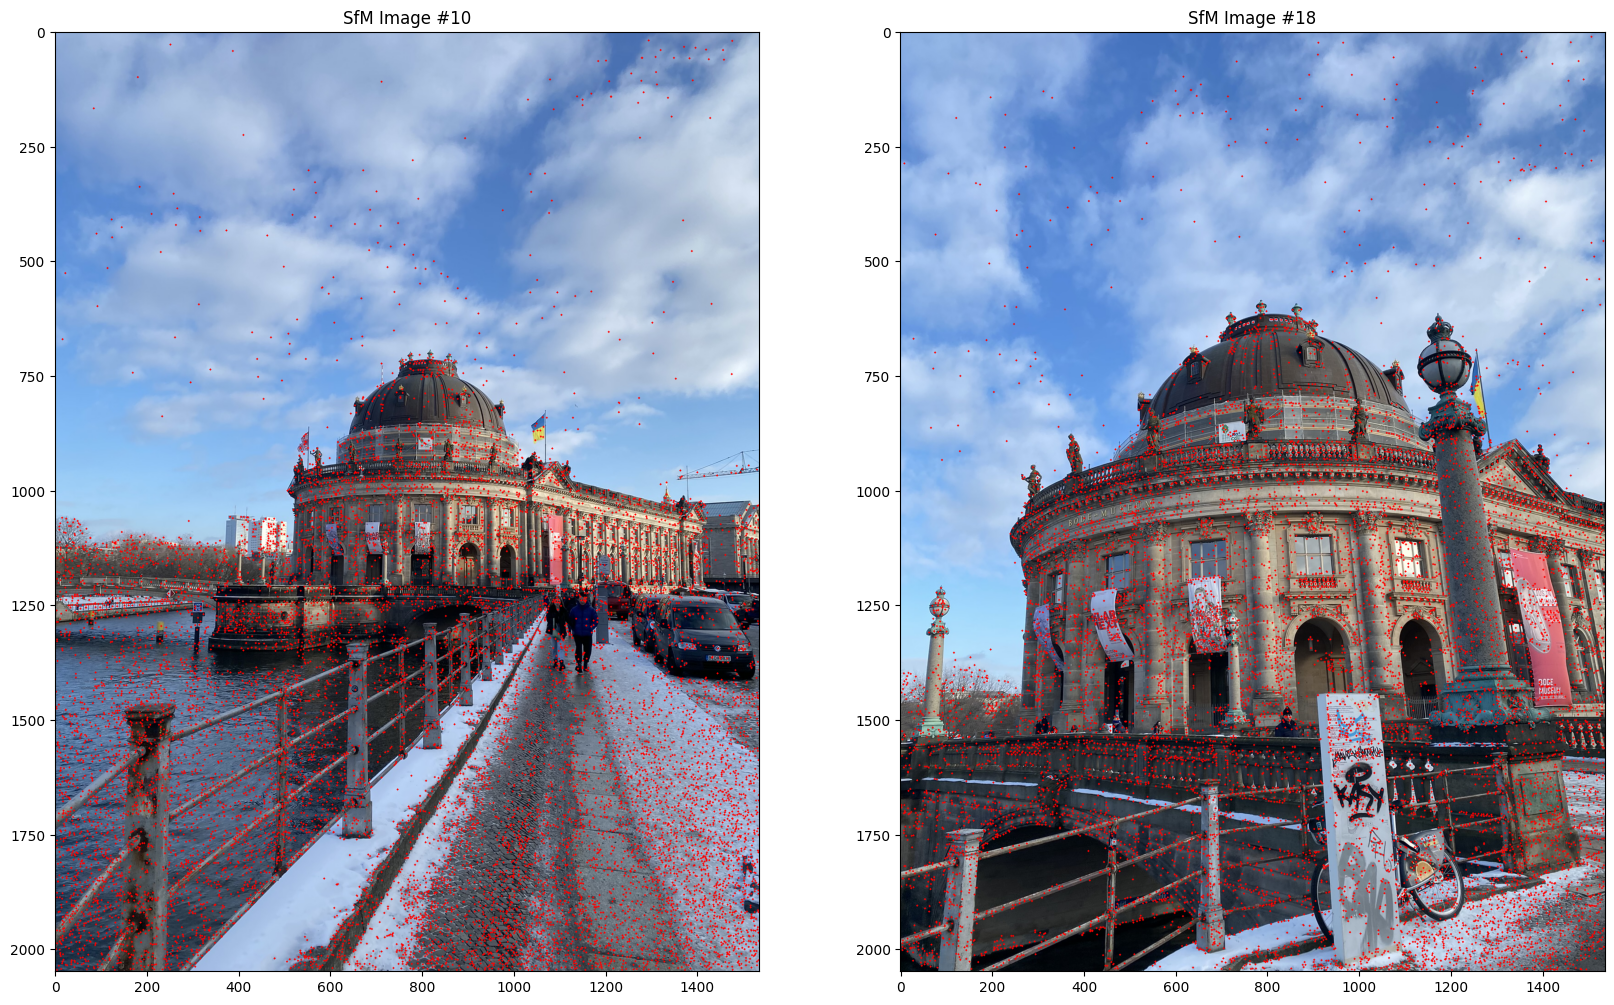

In [6]:
# Display Features for 2 Separate Images
image1_id = 10
image2_id = 18

# Get the image name and features for the given image ID
image1 = get_image(cursor, image1_id)
image2 = get_image(cursor, image2_id)

keypoints1 = get_keypoints(cursor, image1_id)[0]
for i, kpc in enumerate(keypoints1["coordinates"]):
    x = kpc[0]
    y = kpc[1]
    cv2.circle(image1, (int(x), int(y)), radius=2, color=(0,  0,  255), thickness=-1)

keypoints2 = get_keypoints(cursor, image2_id)[0]
for i, kpc in enumerate(keypoints2["coordinates"]):
    x = kpc[0]
    y = kpc[1]
    cv2.circle(image2, (int(x), int(y)), radius=2, color=(0,  0,  255), thickness=-1)

RGB_img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
RGB_img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.rcParams["figure.figsize"] = (20,20)
f, axarr = plt.subplots(1,2)
#plt.imshow(RGB_img)
axarr[0].imshow(RGB_img1)
axarr[0].set_title(f"SfM Image #{image1_id}")
axarr[1].imshow(RGB_img2)
axarr[1].set_title(f"SfM Image #{image2_id}")

plt.show()

# Show the image with features
#cv2.imshow("Image with Features", image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

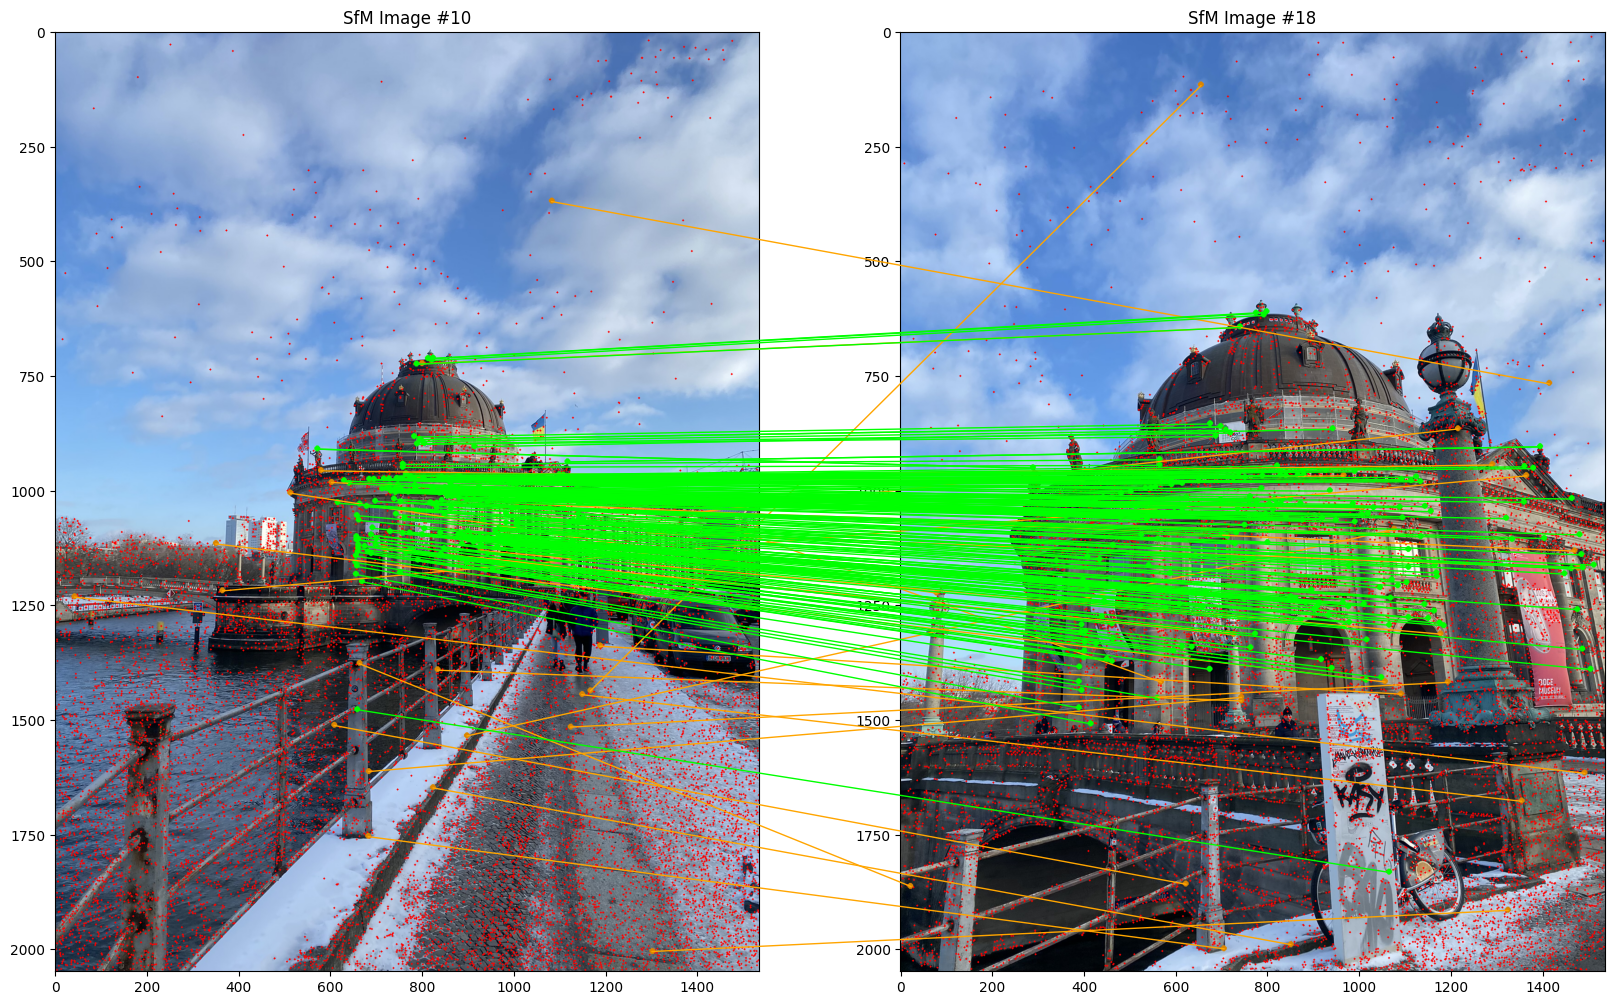

In [12]:
# Display Matched Features on Top (with option of connecting lines between features in images)
from matplotlib.patches import ConnectionPatch

DISPLAY_CONNECT_LINES = True

outlier_matches = get_outlier_matches(cursor, [image1_id, image2_id])
inlier_matches = get_inlier_matches(cursor, [image1_id, image2_id])
if len(outlier_matches) == 0:
    raise Exception("No shared feature matches between both images!")

outlier_matches_coords = get_matches_coords(cursor, outlier_matches[0])
inlier_matches_coords = get_matches_coords(cursor, inlier_matches[0])

def draw_points(matches, color):
    for i, kpc in enumerate(matches):
        kpc1 = kpc[0]
        kpc2 = kpc[1]
        kpc1_x = kpc1[0]
        kpc1_y = kpc1[1]
        kpc2_x = kpc2[0]
        kpc2_y = kpc2[1]
        radius = 2
        cv2.circle(image1, (int(kpc1_x), int(kpc1_y)), radius=radius, color=color, thickness=-1)
        cv2.circle(image2, (int(kpc2_x), int(kpc2_y)), radius=radius, color=color, thickness=-1)
    return

def draw_lines(matches, color):
    for i, kpc in enumerate(matches):
        kpc1 = kpc[0]
        kpc2 = kpc[1]
        kpc1_x = kpc1[0]
        kpc1_y = kpc1[1]
        kpc2_x = kpc2[0]
        kpc2_y = kpc2[1]
        
        # Create a connection patch between the two subplots
        con = ConnectionPatch(xyA=(kpc1_x, kpc1_y), xyB=(kpc2_x, kpc2_y),
                                coordsA="data", coordsB="data",
                                axesA=axarr[0], axesB=axarr[1], color=color)
        # Add the connection patch to the figure, not the axes
        fig.add_artist(con)
    return

draw_points(outlier_matches_coords["image_matches"], (0,  133,  219))
draw_points(inlier_matches_coords["image_matches"], (0,  255,  0))

RGB_img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
RGB_img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plt.rcParams["figure.figsize"] = (20,20)
fig, axarr = plt.subplots(1,2)
#plt.imshow(RGB_img)
axarr[0].imshow(RGB_img1)
axarr[0].set_title(f"SfM Image #{image1_id}")
#axarr[0].axis('off')
axarr[1].imshow(RGB_img2)
axarr[1].set_title(f"SfM Image #{image2_id}")
#axarr[1].axis('off')

# Loop through each keypoint pair and draw lines
if DISPLAY_CONNECT_LINES:
    draw_lines(outlier_matches_coords["image_matches"], "orange")
    draw_lines(inlier_matches_coords["image_matches"], "lime")

plt.show()